## Loopback test

In [32]:
from typing import Tuple

import numpy as np
import numpy.typing
import time
import matplotlib.pyplot as plt

import nidaqmx
from nidaqmx.constants import AcquisitionType, TerminalConfiguration

import pandas as pd

def generate_sine_wave(
    frequency: float,
    amplitude: float,
    sampling_rate: float,
    number_of_samples: int,
    phase_in: float = 0.0,
) -> Tuple[numpy.typing.NDArray[numpy.double], float]:
    """Generates a sine wave with a specified phase.

    Args:
        frequency: Specifies the frequency of the sine wave.
        amplitude: Specifies the amplitude of the sine wave.
        sampling_rate: Specifies the sampling rate of the sine wave.
        number_of_samples: Specifies the number of samples to generate.
        phase_in: Specifies the phase of the sine wave in radians.

    Returns:
        Indicates a tuple containing the generated data and the phase
        of the sine wave after generation.
    """
    duration_time = number_of_samples / sampling_rate
    duration_radians = duration_time * 2 * np.pi
    phase_out = (phase_in + duration_radians) % (2 * np.pi)
    t = np.linspace(phase_in, phase_in + duration_radians, number_of_samples, endpoint=False)

    return (amplitude * np.sin(frequency * t), phase_out)

def plot_diff_se(
    df,
    time_col='time',
    channels=('diff','se'),
    start_time=None,
    stop_time=None,
    start_sample=None,
    stop_sample=None,
    fmin=None,
    fmax=None,
    fft_db=False,
    fft_norm=False,
    fft_ref='V',        # 'V' for dBV, 'FS' for dBFS
    separate_plots=False
):
    """
    Plot 'diff' and 'se' channels from df in both time and frequency domains.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns time_col and each channel in `channels`.
    time_col : str
        Name of the time column in df (in seconds).
    channels : tuple of str
        Names of the two signals to plot.
    start_time, stop_time : float or None
        If given, trim the time‑domain plot to this window (in same units as df[time_col]).
    start_sample, stop_sample : int or None
        If given, trim by row index instead of time. Overrides start_time/stop_time.
    fmin, fmax : float or None
        X‑axis limits for the FFT plot (in Hz).
    fft_db : bool
        If True, plot FFT magnitude in dB (20·log10); otherwise plot linear magnitude.
    fft_norm : bool
        If True, normalize FFT by 2/N so that a sine of amplitude A shows up as A.
    fft_ref : str
        Reference label for dB axis ('V' for dBV, 'FS' for dBFS).
    separate_plots : bool
        If True, draw each channel in its own figure; if False, overlay both channels.
    """
    # 1) slice the DataFrame
    if start_sample is not None or stop_sample is not None:
        sel = df.iloc[start_sample:stop_sample]
    else:
        sel = df.copy()
        if start_time is not None:
            sel = sel[sel[time_col] >= start_time]
        if stop_time is not None:
            sel = sel[sel[time_col] <= stop_time]

    t = sel[time_col].values
    sigs = [sel[ch].values for ch in channels]

    # 2) time-domain plots
    if separate_plots:
        for sig, ch in zip(sigs, channels):
            plt.figure(figsize=(8,3))
            plt.plot(t, sig)
            plt.title(f"{ch} — Time Domain")
            plt.xlabel(f"{time_col} [s]")
            plt.ylabel("Amplitude [V]")
            plt.tight_layout()
    else:
        plt.figure(figsize=(8,3))
        for sig, ch in zip(sigs, channels):
            plt.plot(t, sig, label=ch)
        plt.title("Time-Domain Signals")
        plt.xlabel(f"{time_col} [s]")
        plt.ylabel("Amplitude [V]")
        plt.legend()
        plt.tight_layout()

    # 3) sampling rate and N
    if len(t) < 2:
        raise ValueError("Not enough points for FFT.")
    dt = t[1] - t[0]
    N  = len(t)

    # 4) FFT and optional normalization
    freqs = np.fft.rfftfreq(N, d=dt)
    ffts  = [np.abs(np.fft.rfft(sig)) for sig in sigs]  # <-- fixed list comprehension

    if fft_norm:
        ffts = [fft * (2.0 / N) for fft in ffts]

    if fft_db:
        eps = np.finfo(float).eps
        ffts = [20*np.log10(fft + eps) for fft in ffts]

    # 5) frequency-domain plots
    ylabel = "Magnitude"
    if fft_db:
        ylabel += f" (dB{fft_ref})"

    if separate_plots:
        for fft, ch in zip(ffts, channels):
            plt.figure(figsize=(8,3))
            plt.plot(freqs, fft)
            plt.title(f"{ch} — Frequency Domain")
            plt.xlabel("Frequency [Hz]")
            plt.ylabel(ylabel)
            if fmin is not None or fmax is not None:
                plt.xlim(fmin or freqs.min(), fmax or freqs.max())
            plt.tight_layout()
    else:
        plt.figure(figsize=(8,3))
        for fft, ch in zip(ffts, channels):
            plt.plot(freqs, fft, label=ch)
        plt.title("Frequency-Domain Signals")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel(ylabel)
        if fmin is not None or fmax is not None:
            plt.xlim(fmin or freqs.min(), fmax or freqs.max())
        plt.legend()
        plt.tight_layout()

    plt.show()

In [37]:

    """Continuously generates a sine wave."""
    with nidaqmx.Task() as ai_task, nidaqmx.Task() as ao_task:
         # DIFF measruemt channel
        ai_task.ai_channels.add_ai_voltage_chan(
            physical_channel = "Dev1/ai0",
            terminal_config=TerminalConfiguration.DIFF,
            min_val=-1, max_val=1
        )
        # SE measruemt channel
        ai_task.ai_channels.add_ai_voltage_chan(
            physical_channel = "Dev1/ai1",
            terminal_config=TerminalConfiguration.RSE,
            min_val=-1, max_val=1
        )
        ai_task.timing.cfg_samp_clk_timing(
            rate=1000000,
            sample_mode=AcquisitionType.FINITE,
            samps_per_chan=100000
        )
        actual_sampling_rate_input = ai_task.timing.samp_clk_rate

        # Analog Output configuration
        ao_task.ao_channels.add_ao_voltage_chan(
            physical_channel="Dev1/ao0",
            min_val=-2, max_val=2
        )
        ao_task.timing.cfg_samp_clk_timing(
            samps_per_chan=10000,
            rate=250000,
            sample_mode=AcquisitionType.CONTINUOUS,
        )

        actual_sampling_rate_output = ao_task.timing.samp_clk_rate
        
        sine_wave, _ = generate_sine_wave(
                frequency = 1000,
                amplitude = 0.5,
                sampling_rate=actual_sampling_rate_output,
                number_of_samples= 10000,
            )
        ao_task.write(sine_wave, auto_start=False)

         # Start both tasks 
        ao_task.start()
        time.sleep(1)
        ai_task.start()
        ai_task.wait_until_done(timeout=20.0)
        ao_task.stop()

        data = ai_task.read(100000)
        t_input = np.linspace(0, 100000/actual_sampling_rate_input, 100000, endpoint=False)

        meas_data = pd.DataFrame({
                    'diff': np.array(data[0]),
                    'se': np.array(data[1]),            
                    'time': t_input
                    })




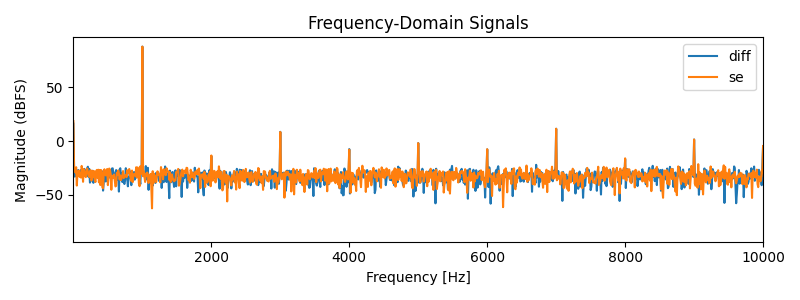

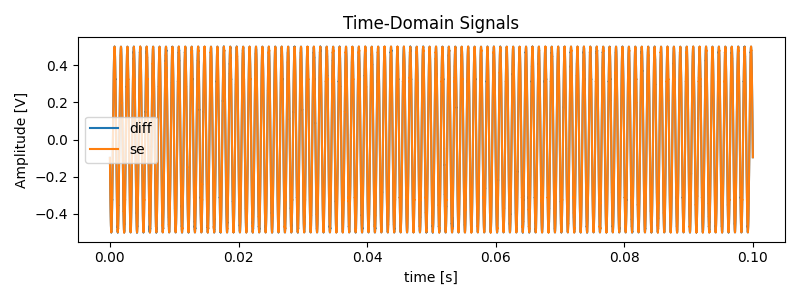

In [39]:
%matplotlib widget
plot_diff_se(meas_data, fft_db = True, separate_plots=False, fft_ref= 'FS', fmin=0.1, fmax=10000)